### Exploring gradient descent based optimizers

Notebook to understand the working of various gradient descent based optimisers. We'll be exploring the simplest possible supervised learning algorithm as a use case - i.e. linear regression. It helps understand what are the shortcomings of different optimizers and how it is overcome using the newer methods.

Optimizers are used to optimize the model parameters in any learning algorithm. They basically differ in what is the update step given the current parameter values and the gradient values for all parameters. Updating the parameters to minimize loss function is very similar to the real life example of a person trying to reach the bottom of a valley. At any point, you only know where you are, and the directions of maximum change (gradient) in your neighbourhood. You keep moving in direction of maximum downward slope it until you find that the slope is going upward in all your surroundings.

Optimizers added:
* Gradient Descent
* Mini batch gradient descent
* Momentum
* Nesterov
* Adagrad
* Adadelta
* RMSProp
* Adam
* Adamax
* Nadam

Author: Falak Shah, Jayendra Parmar

In [1]:
%matplotlib inline

# import stuff 
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Synthetically creating points around the line 
$$
y = ax + b
$$
by adding noise to the output. So, effectively,  
$$
y = ax + b + w, \quad where 
$$
$$
w \in N(0, \sigma^2)
$$

In [2]:
# Some global stuff, will be used a lot down the line 
# Do not overwrite these!!
a = 2
b = 25
sigma = 0.5

x = np.arange(-20, 20, 0.05)                       # 40/0.05 = 800 data points
y = a * x + b + sigma * np.random.randn(x.shape[0])

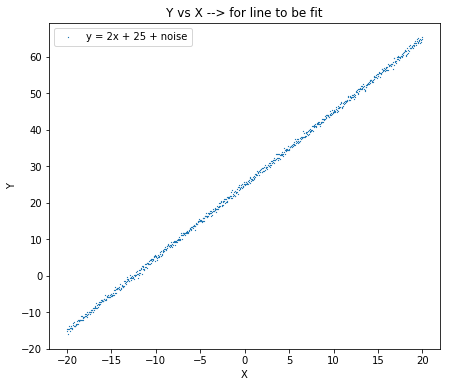

In [3]:
plt.figure(figsize = [7,6])
plt.scatter(x, y, marker='x', s=0.1)
plt.title('Y vs X --> for line to be fit')
plt.xlabel('X'); plt.ylabel('Y')
plt.legend( ['y = ' + str(a) + 'x + ' + str(b) +' + noise'])

The data is shown above. It is basically a line with some gaussian noise added. Here we know the true value of the parameters of the line, i.e. a and b. 


In a supervised learning problem setting, the task would be to determine a and b. We start with some initial pair (a,b) and moving as per the directions of the optimizer till we find the value of (a,b) minimizes the mean squared error over all data points (global minima) or a batch of data points (local minima). 

The loss function can be expressed as: 
$$
J = \frac{1}{2}\sum_{i=1}^n(y_i - (a x_i + b) )^2 
$$
$$
(a_{opt}, b_{opt}) = \underset{a,b}{\mathrm{argmin}} (J)
$$
The factor of 1/2 can be discarded without any change in results but is kept for now for ease of gradients computation.

In [4]:
# Compute loss for single a,b or a full grid of them 
def compute_loss(a_est, b_est):
    return np.mean(np.square(y - (a_est * x + b_est)),2)

In [5]:
# Some tricky matrix manipulations in this cell. The main goal is to visualize the loss function for all values of a and b.
a_explore_range = 20
a_explore_step = 0.1

# Since b has less impact on loss function, moving to larger values
b_explore_range = 200
b_explore_step = 1

# We can chnage above values to see how the parameters impact the model

# Get full ranges of a and b
a_est_range = np.arange(a - a_explore_range, a + a_explore_range, a_explore_step)
b_est_range = np.arange(b - b_explore_range, b + b_explore_range, b_explore_step)

# Make them into a grid. b first, as we want a to change along rows
bgrid, agrid = np.meshgrid(b_est_range, a_est_range)

# I absolutely hate for loops and I know linear algebra, hence this bit of code
# We are doing this is because the x and y are vectors
size_x = np.int(a_explore_range / a_explore_step * 2)
size_y = np.int(b_explore_range / b_explore_step * 2)
agrid_tiled = np.tile(np.reshape(agrid, [size_x, size_y, 1]), [1,1,x.shape[0]])
bgrid_tiled = np.tile(np.reshape(bgrid, [size_x, size_y,1]), [1,1,x.shape[0]])

# Whoosh! Loss for the full grid at once
loss_full_grid = compute_loss(agrid_tiled, bgrid_tiled)

Text(0.5,0.92,'Visualization of the loss function')

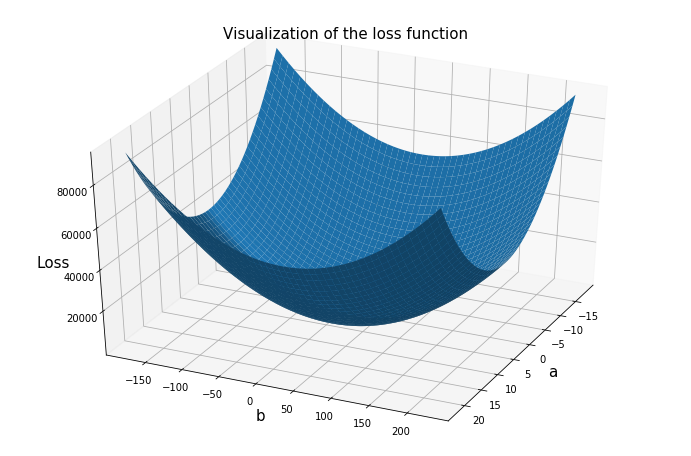

In [6]:
# Change these values and move around the plot to look at it from different angles
azimuth_angle = 25.
elevation_angle = 35

fig = plt.figure(figsize = [12,8])
ax = fig.add_subplot(111, projection = '3d')
ax.view_init(elev = elevation_angle, azim = azimuth_angle)
ax.plot_surface(agrid, bgrid, loss_full_grid)
ax.set_xlabel('a', fontsize=15);  ax.set_ylabel('b', fontsize=15)
ax.set_zlabel('Loss', fontsize=15)
ax.set_title('Visualization of the loss function', fontsize=15)
#ax.set_aspect('equal')

### The loss function

Observe the loss function across a grid of different parameter values. The blue curve at any point is the loss for a particular set of parameters(a,b) as shown in the figure. Notice how the decline or rise in loss is much steeper when changing a as compared to changing b. This is even more evident in the plots shown below.

Some optimizers have trouble navigating along such loss functions as we'll observe. Also, this curve is obviously convex, and a very clean one at it. Do not expect such clean loss functions in real life.  

Text(0.5,1,'Mean loss values across for different b values')

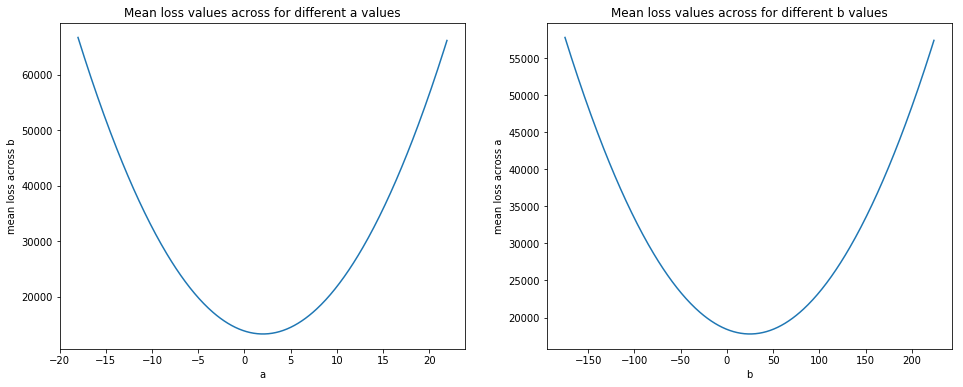

In [7]:
plt.figure(figsize = [16,6])
plt.subplot(121)
plt.plot(a_est_range, np.mean(loss_full_grid, axis=1))
plt.xlabel('a')
plt.ylabel('mean loss across b')
plt.title('Mean loss values across for different a values')
plt.subplot(122)
plt.plot(b_est_range, np.mean(loss_full_grid, axis=0))
plt.xlabel('b')
plt.ylabel('mean loss across a')
plt.title('Mean loss values across for different b values')

### Linear regression problem mathematical formulation

We are trying to fit the line 
$$
y = ax + b
$$
or in other words minimize the loss function
$$
J = \frac{1}{2}\sum_{i=1}^n(y_i - (a x_i + b) )^2 
$$
$$
J = \frac{1}{2}\sum_{i=1}^n (y_i^2 + (a x_i)^2 + b^2 + 2ax_ib - 2ax_iy_i - 2y_ib)
$$

We can generalize above equation, here we can see that loss is a function of just 2 parameters $a$ and $b$. So let's say $\theta = [a,b]$, then the loss is $ J(\theta) $. From here on, $\theta$ is the set of parameters to be updated.

### Direct solution - pseudo inverse

Pseudo inverse of the features matrix x multiplied with y gives the solution to this mean squared minimization or regression problem directly. This can be expressed as :
$$
   Y= XA 
$$

$$
A = (X^T X)^{-1}X^T Y
$$

where $X$ is the features set with a column of 1's appended for the bias value computation 

In [8]:
x_ext  = np.expand_dims(x, axis=1)
y_ext  = np.expand_dims(y, axis=1)
x_ext  = np.concatenate((x_ext, np.ones_like(x_ext)), 1)

astar, bstar = np.dot(np.dot(np.linalg.inv(np.dot(x_ext.T, x_ext)),x_ext.T),y_ext)
print(astar, bstar)

astar2, bstar2 = np.dot(np.linalg.pinv(x_ext), y_ext)
print(astar2, bstar2)

[2.00106975] [24.99224579]
[2.00106975] [24.99224579]


### Gradients computation
Computing the gradients w.r.t a and b, we have
$$
J = \frac{1}{2}\sum_{i=1}^n(y_i - (a x_i + b) )^2 
$$

$$
\frac{\partial J}{\partial a} = \frac{1}{2}\sum_{i=1}^n (2ax_i^2 + 2x_ib - 2x_iy_i) 
$$

$$
\frac{\partial J}{\partial a} = \sum_{i=1}^n x_i (ax_i + b - y_i )
$$

$$
\frac{\partial J}{\partial b} = \sum_{i=1}^n (ax_i + b - y_i )
$$

$$
\nabla J = ( \frac{\partial J}{\partial a} , \frac{\partial J}{\partial b})
$$

In [9]:
# Utility functions  - mostly self explanatory if you read the above ideas

# Hard coded for the line - not a good idea..,but for now
def gradient(x, y, theta):
    a,b = theta[0], theta[1]
    temp_err = a * x + b - y
    loss = sum(temp_err * temp_err)
    grad_a = sum(x * temp_err)
    grad_b = sum(temp_err)
    return np.array([grad_a, grad_b]), loss

# It does what the name says it does..
def get_random_batch(x, y, batch_size):
    i = np.random.randint(0, x.shape[0]-1, size = batch_size)
    return(x[i], y[i])

# Move these below 2 functions out of the notebook!!
def plot_all_results(grad_store, abvalue_store, loss_store, velocity_store = None):
    plt.figure(figsize = [20, 12])
    plt.subplot(231)
    plt.plot(grad_store[:,0])
    plt.title('Gradient of loss wrt a'); plt.xlabel("# Steps")
    plt.ylabel(r'$\frac{\partial loss}{\partial a}$')
    plt.subplot(232)
    plt.plot(grad_store[:,1])
    plt.title('Gradient of loss wrt b'); plt.xlabel("# Steps")
    plt.ylabel(r'$\frac{\partial loss}{\partial b}$')
    plt.subplot(233)
    plt.plot(abvalue_store[:,0])
    plt.title('"a" values'); plt.xlabel("# Steps")
    plt.ylabel('a')
    plt.subplot(234)
    plt.plot(abvalue_store[:,1])
    plt.title('"b" values'); plt.xlabel("# Steps")
    plt.ylabel('b')
    plt.subplot(235)
    plt.plot(loss_store)
    plt.title("Loss"); plt.xlabel("# Steps")
    plt.ylabel('loss')
    if velocity_store is not None:
        plt.subplot(236)
        plt.plot(velocity_store[:, 0])
        plt.plot(velocity_store[:, 1], 'r*')
        plt.legend(['Velocity of grad_a', 'Velocity of grad_b'])

# Empty spaces for filling in stuff. Storing since we'll need them for plotting
def init_data_store(num_epochs):
    grad_store = np.zeros([num_epochs, 2], dtype=float)
    abvalue_store = np.zeros([num_epochs, 2], dtype=float)
    loss_store = np.zeros([num_epochs, 1], dtype=float)
    velocity_store = np.zeros([num_epochs, 2], dtype=float)
    
    return grad_store, abvalue_store, loss_store, velocity_store

# Let's shuffle the array
ix = np.arange(0,x.shape[0])
np.random.shuffle(ix)
x = x[ix]
y = y[ix]

#getting the batch of data for passed indices
def get_data_from_batch(x,y,idx,batch_size):
    start_ix = idx*batch_size
    end_ix   = min(start_ix + batch_size, x.shape[0])
    return (x[start_ix:end_ix], y[start_ix:end_ix])

### Batch Gradient Descent

* Simplest of all optimizers
* Just one parameter - learning rate (denoted by $\eta$)
* Move in the direction opposite of the gradient
* Guaranteed to converge to global optimum (convex function) and local optimum otherwise


**Update rule**
$$
\theta_t = \theta_{t-1} - \eta \cdot \nabla J(\theta_{t-1})
$$

**Cons**
* Memory intensive - loads the full dataset and computes gradients


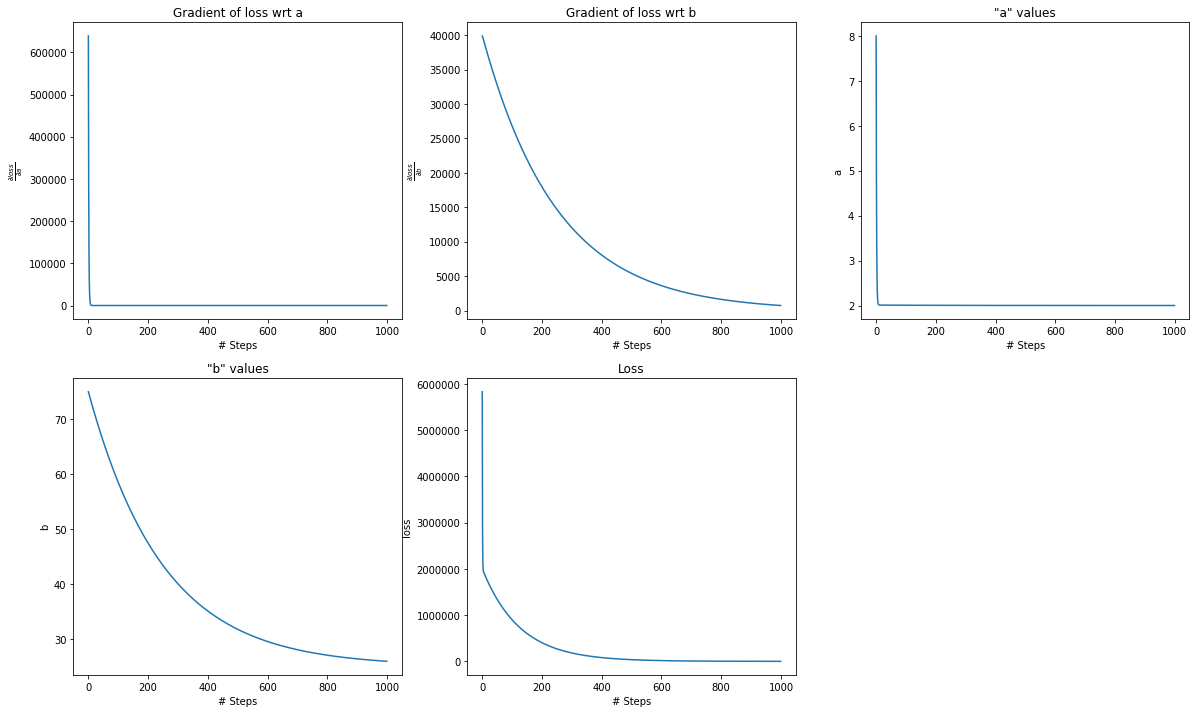

In [10]:
# Batch gradient descent

initial_a = 8
initial_b = 75
num_epochs = 1000
eta = 5e-6

grad_store, abvalue_store, loss_store, _ = init_data_store(num_epochs)

theta = np.array([initial_a, initial_b])

for i in range(num_epochs):
    abvalue_store[i,:] = theta
    
    #calculate gradient
    grad, loss = gradient(x,y, theta)
    
    #update rule
    delta_theta = eta * grad
    theta = theta - delta_theta
    
    # storing them to display later
    grad_store[i] = grad
    loss_store[i] = loss
    
plot_all_results(grad_store, abvalue_store, loss_store)

### Mini batch gradient descent

This is the same as above gradient descent, except that the update is performed on a mini batch of user specified size. 

* Less memory intensive
* Noisy convergence
* More commonly used in neural nets/ problems that don't fit in memory

**Update rule** 
$$
\theta_t = \theta_{t-1} - \eta \cdot \nabla J_{batch}(\theta_{t-1})
$$

where $J_{batch}$ is the loss over the mini batch under process

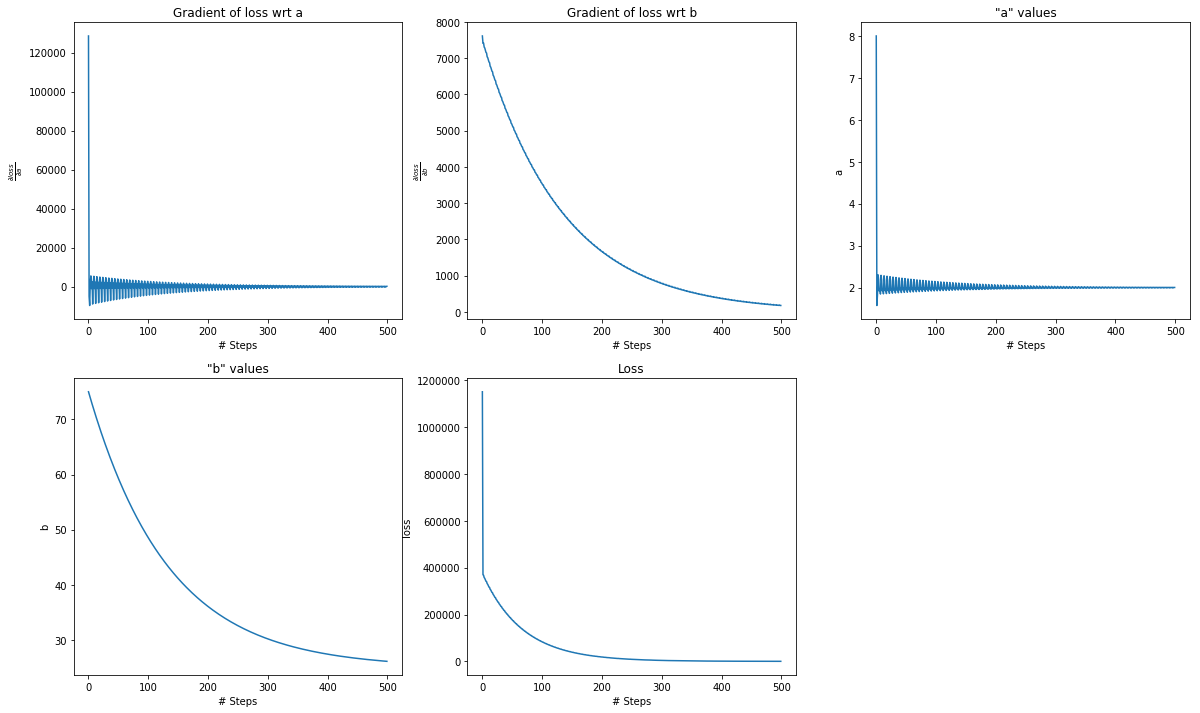

In [11]:
# Mini batch gradient descent

initial_a = 8
initial_b = 75
num_epochs = 100
eta = 5e-5
batch_size = 150 # Lower this and watch the plots grow messy
n_batches = int(x.shape[0]/batch_size)

grad_store, abvalue_store, loss_store, velocity_store = init_data_store(num_epochs*n_batches)

theta = np.array([initial_a, initial_b])

i=0
for epoch in range(num_epochs):   
    for batch_idx in range(n_batches):
        abvalue_store[i] = theta
        x_batch, y_batch = get_data_from_batch(x,y, batch_idx, batch_size)
        
        #calculate gradient
        grad, loss = gradient(x_batch, y_batch, theta)
        
        # update parameters
        theta = theta - eta * grad
        
        grad_store[i] = grad
        loss_store[i] = loss
        i += 1
    
plot_all_results(grad_store, abvalue_store, loss_store)

Observe the noisy convergence in the above case when we used mini batches of data. Vary the batch size parameter above and observe the variations in the result. 

### Momentum

* To lead to faster convergence when gradient changes slowly along one of the dimensions as is the case above

$$
v_t = \gamma v_{t-1} + \eta \nabla J(\theta_{t-1})
$$

$$
\theta_t = \theta_{t-1} - v_t
$$

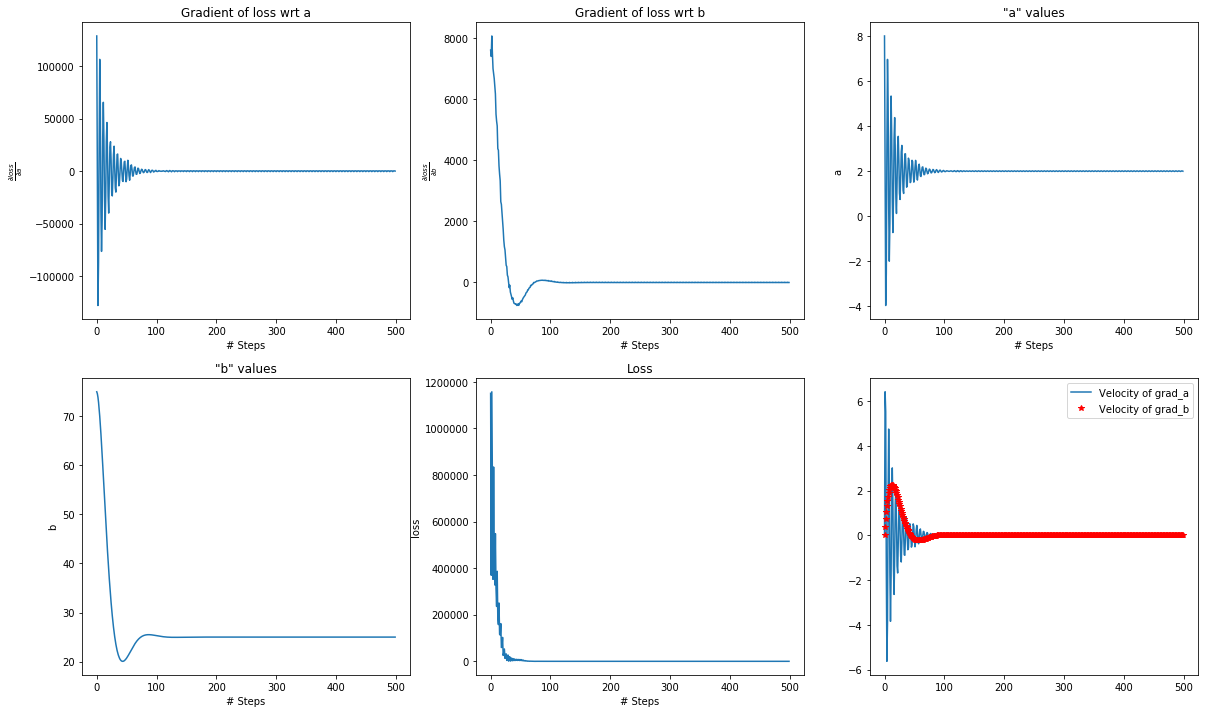

In [12]:
initial_a = 8
initial_b = 75
num_epochs = 100
eta = 5e-5
batch_size = 150 # Lower this and watch the plots grow messy
n_batches = int(x.shape[0]/batch_size)
gamma = 0.9

grad_store, abvalue_store, loss_store, velocity_store = init_data_store(num_epochs*n_batches)


theta = np.array([initial_a, initial_b])
velocity = np.array([0, 0])

i=0
for epoch in range(num_epochs):   
    for batch_idx in range(n_batches):
        abvalue_store[i] = theta
        velocity_store[i] = velocity
        
        x_batch, y_batch = get_data_from_batch(x,y, batch_idx, batch_size)
        
        # calculate gradient
        grad, loss = gradient(x_batch, y_batch, theta)
        
        # update rule
        velocity = gamma* velocity + eta * grad
        theta = theta - velocity
        
        # store
        grad_store[i] = grad
        loss_store[i] = loss
        i += 1
    
plot_all_results(grad_store, abvalue_store, loss_store, velocity_store)

### Nesterov

* To prevent the ball from sliding up the other slope with all the momentum it gained while coming down

$$
v_t = \gamma v_{t-1} + \eta \nabla J(\theta_{t-1} - \gamma v_{t-1})
$$

$$
\theta_t = \theta_{t-1} - v_t
$$

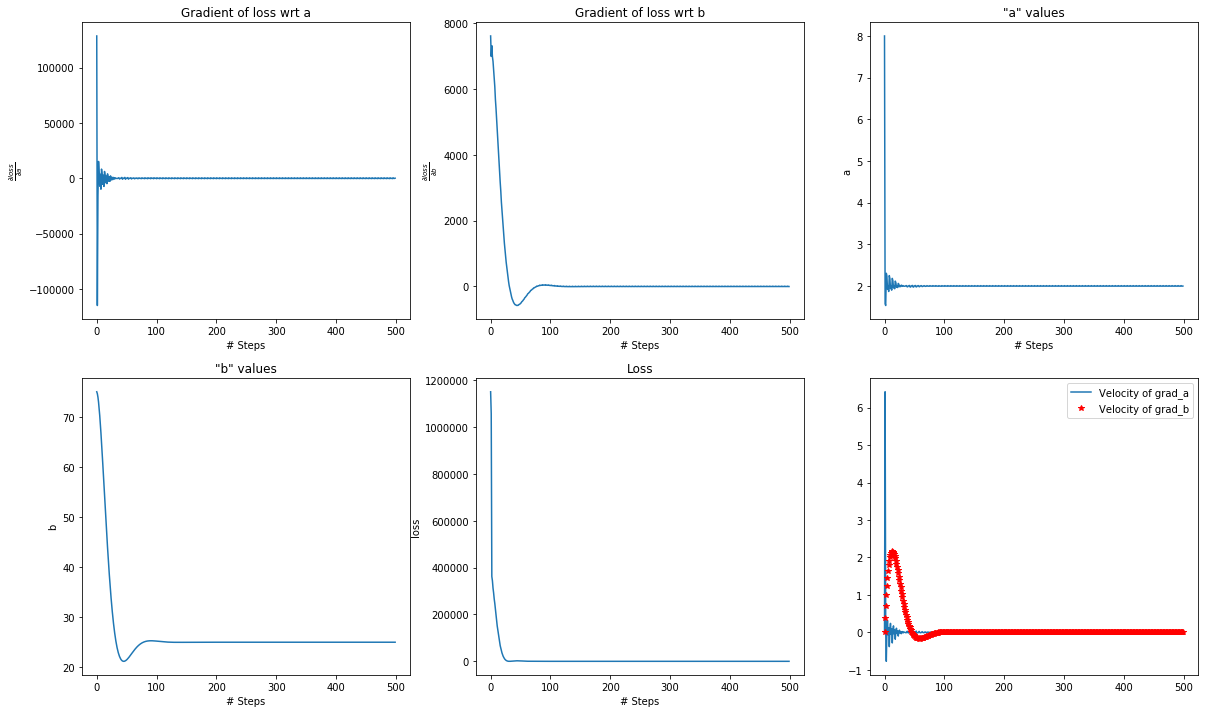

In [13]:
initial_a = 8
initial_b = 75
num_epochs = 100
eta = 5e-5
batch_size = 150 # Lower this and watch the plots grow messy
n_batches = int(x.shape[0]/batch_size)
gamma = 0.9

grad_store, abvalue_store, loss_store, velocity_store = init_data_store(num_epochs*n_batches)

theta = np.array([initial_a, initial_b])
velocity = np.array([0, 0])

i=0
for epoch in range(num_epochs):   
    for batch_idx in range(n_batches):
        abvalue_store[i] = theta
        velocity_store[i] = velocity
        
        x_batch, y_batch = get_data_from_batch(x,y, batch_idx, batch_size)
        
        # computing gradient at lookahead theta
        look_ahead_theta = theta - gamma*velocity
        grad, loss = gradient(x_batch, y_batch, look_ahead_theta)
        
        # update the params
        velocity = gamma* velocity + eta * grad
        theta = theta - velocity
        
        grad_store[i] = grad
        loss_store[i] = loss
        i += 1
    
plot_all_results(grad_store, abvalue_store, loss_store, velocity_store)

### Adagrad

Adagrad is an algorithm for gradient-based optimization that does just this: It adapts the learning rate to the parameters, performing larger updates for infrequent and smaller updates for frequent parameters. For this reason, it is well-suited for dealing with sparse data.

$$
\theta_{t,i} = \theta_{t-1,i} - \frac{\eta }{\sqrt{G_{t,ii} + \epsilon}} \cdot \nabla J(\theta_{t-1,i})
$$

where $G_{t,ii} \in R^{d×d}$ is a diagonal matrix where each diagonal element i, i is the sum of the squares of the
gradients w.r.t. the parameter up to time step $t$, while $\epsilon$ is a smoothing term that avoids division by zero (usually
on the order of 1e-8)

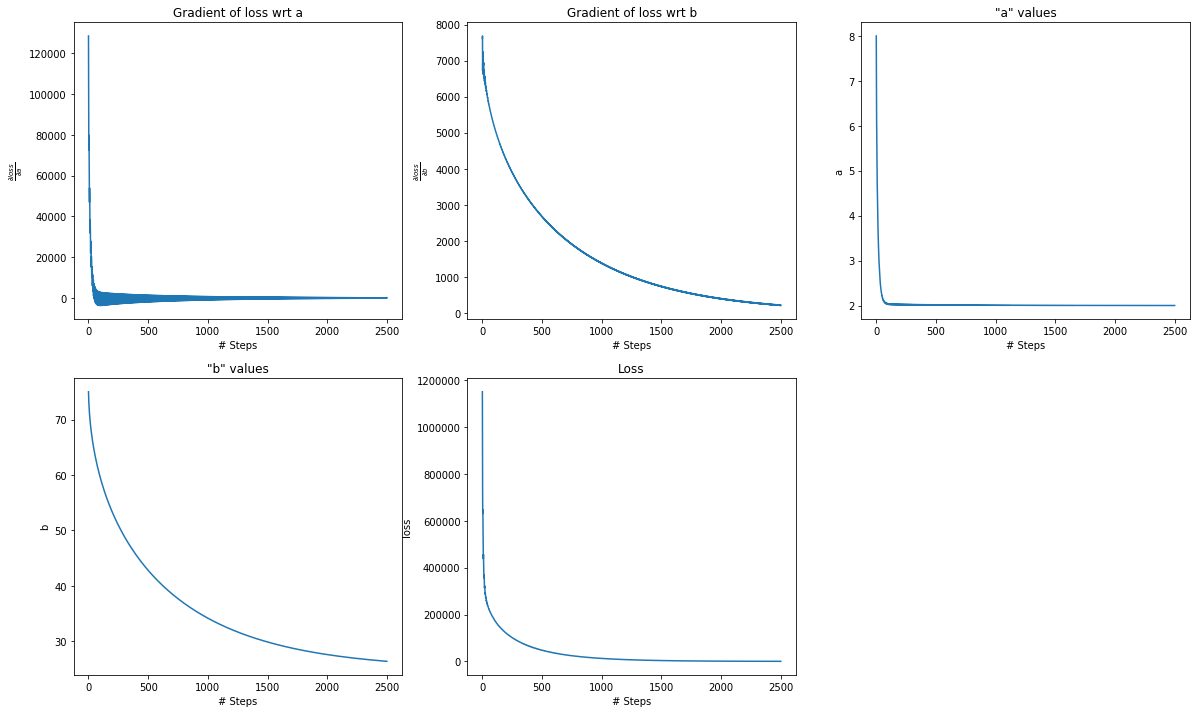

In [14]:
initial_a = 8
initial_b = 75
num_epochs = 500
eta = 0.9
batch_size = 150 # Lower this and watch the plots grow messy
n_batches = int(x.shape[0]/batch_size)
eps = 1e-8

grad_store, abvalue_store, loss_store, velocity_store = init_data_store(num_epochs*n_batches)

theta = np.array([initial_a, initial_b])

i=0
for epoch in range(num_epochs):   
    for batch_idx in range(n_batches):
        abvalue_store[i] = theta
        
        # get the batch
        x_batch, y_batch = get_data_from_batch(x,y, batch_idx, batch_size)
        
        # Compute the gradient
        grad, loss = gradient(x_batch, y_batch, theta)
        grad_store[i] = grad
        
        # Compute G and update params
        G = np.sum(np.square(grad_store), axis=0)
        theta = theta - eta * grad / np.sqrt(G + eps)
        
        loss_store[i] = loss
        i += 1
    
plot_all_results(grad_store, abvalue_store, loss_store)

### Adadelta / (RMSProp)

Adadelta is an extension of Adagrad that seeks to reduce its aggressive, monotonically decreasing learning rate. Instead of accumulating all past squared gradients, Adadelta restricts the window of accumulated past gradients to some fixed size w

$$ E[g^2]_t = \gamma E[g^2]_{t-1} + (1 - \gamma) g^2_t $$ where $g_t = \nabla J(\theta)$

$$
\theta_{t,i} = \theta_{t-1,i} - \frac{\eta }{\sqrt{E[g^2]_{t,i} + \epsilon}} \cdot \nabla J(\theta_{t-1,i})
$$

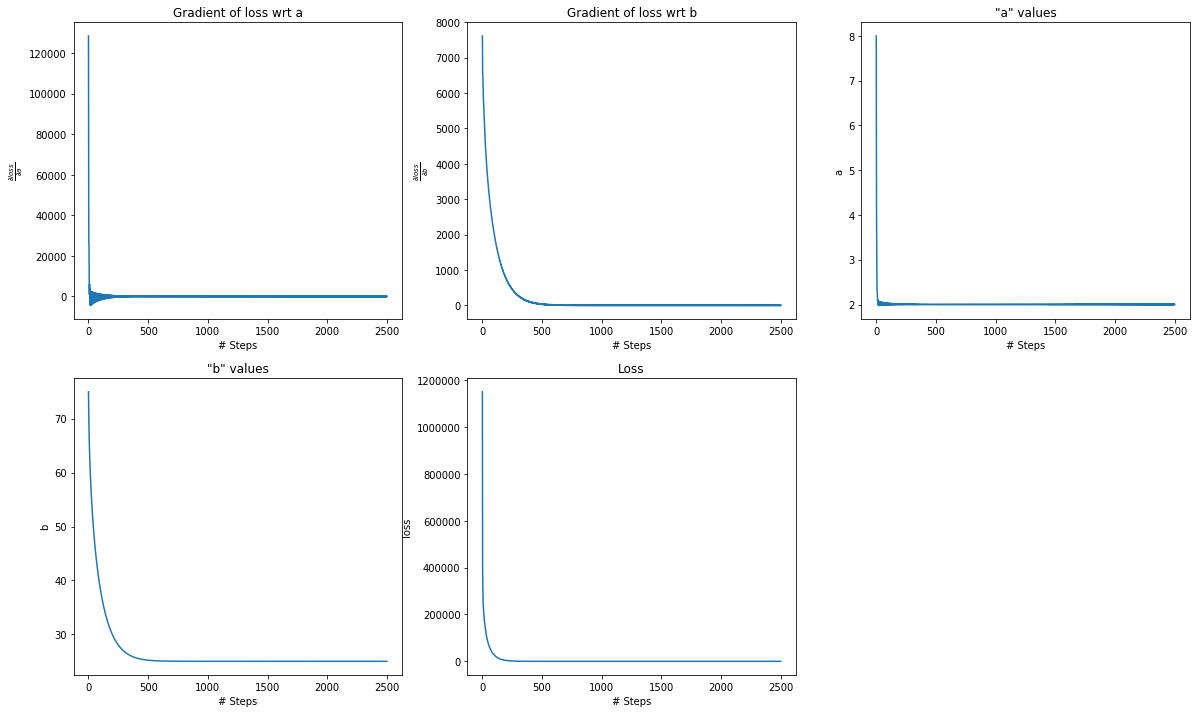

In [15]:
initial_a = 8
initial_b = 75
num_epochs = 500
eta = 8e-2
batch_size = 150 # Lower this and watch the plots grow messy
n_batches = int(x.shape[0]/batch_size)
eps = 1e-8
gamma = 0.999

grad_store, abvalue_store, loss_store, velocity_store = init_data_store(num_epochs*n_batches)

theta = np.array([initial_a, initial_b])
i=0
expected_grad = np.array([0,0])
for epoch in range(num_epochs):   
    
    for batch_idx in range(n_batches):
        
        abvalue_store[i] = theta
        
        # get the data and compute gradient 
        x_batch, y_batch = get_data_from_batch(x,y, batch_idx, batch_size)
        grad, loss = gradient(x_batch, y_batch, theta)
        
        # compute update rule
        expected_grad = gamma * expected_grad + (1 - gamma) * np.square(grad)
        RMS_grad = np.sqrt(expected_grad + eps)
        delta_theta = -(eta/RMS_grad) * grad
        
        theta = theta + delta_theta
        grad_store[i] = grad
        loss_store[i] = loss
        i += 1
    
plot_all_results(grad_store, abvalue_store, loss_store)

### Adam

Adaptive Moment Estimation (Adam) is another method that computes adaptive learning rates for each parameter. In addition to storing an exponentially decaying average of past squared gradients $v_t$ like Adadelta and RMSprop, Adam also keeps an exponentially decaying average of past gradients $m_t$, similar to momentum

here $g_t = \nabla J(\theta)$
$$
m_t = \beta_1 m_{t-1} + (1 - \beta_1)g_t
$$

$$
v_t = \beta_2v_{t-1} + (1 - \beta_2)g^2_t 
$$

$$
\hat{m_t} = \frac{m_t}{1 - \beta_1^t}
$$

$$
\hat{v_t} = \frac{v_t}{1 - \beta_2^t}
$$

$$ \theta_{t} = \theta_{t-1} - \frac{\eta }{\sqrt{\hat{v}_{t-1} + \epsilon}} \cdot \hat{m}_{t-1} $$

Wall time: 107 ms


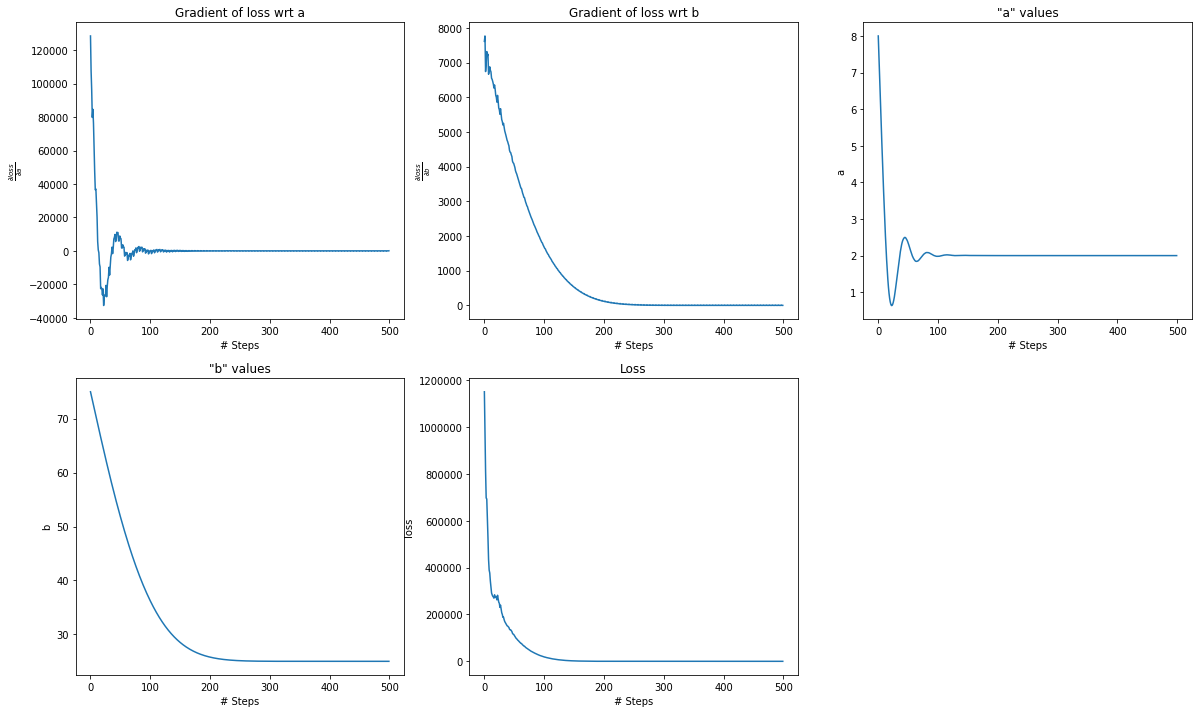

In [16]:
%%time
initial_a = 8
initial_b = 75
num_epochs = 100
epsilon = 1e-8
theta = np.array([initial_a, initial_b])
beta1 = 0.9
beta2 = 0.999
batch_size = 150
eta = 5e-1
n_batches = int(x.shape[0]/batch_size)
grad_store, abvalue_store, loss_store, velocity_store = init_data_store(num_epochs*n_batches)


mt = np.array([0, 0])
vt = np.array([0, 0])

i=0
for epoch in range(num_epochs):
    
    for batch_idx in range(n_batches):
        
        abvalue_store[i] = theta
        
        # get data and compute gradient
        x_batch, y_batch = get_data_from_batch(x,y, batch_idx, batch_size)
        grad, loss = gradient(x_batch, y_batch, theta)

        # approximate first and second moment
        mt = beta1 * mt + (1 - beta1) * grad
        vt = beta2 * vt + (1 - beta2) * np.square(grad)
    
        # bias corrected moment estimates
        mhat = mt / (1 - beta1 ** (i+1) )
        vhat = vt / (1 - beta2 ** (i+1) )
        
        # update the params
        delta_theta = -1 * eta * mhat/(np.sqrt(vhat) + epsilon)
        theta = theta + delta_theta
        
        grad_store[i,:] = grad
        loss_store[i] = loss
        i += 1
        
plot_all_results(grad_store, abvalue_store, loss_store)

## AdaMax
Norms for large p values generally become numerically unstable, which is why $l_1$ and $l_2$ norms are
most common in practice. However, $l_\infty$ also generally exhibits stable behavior. For this reason, the
authors propose AdaMax and show that vt with $l_\infty$ converges to the following more stable value

here $g_t = \nabla J(\theta)$
$$
m_t = \beta_1 m_{t-1} + (1 - \beta_1)g_t
$$

$$
u_t = \beta^\infty_2 u_{t-1} + (1 - \beta_2^\infty)|g_t|^\infty
$$

$$
u_t = max(\beta_2 \cdot u_{t-1}, |g_t|) 
$$

$$
\theta_{t} = \theta_{t-1} - \eta \frac{m_t}{u_t}
$$

Wall time: 88.8 ms


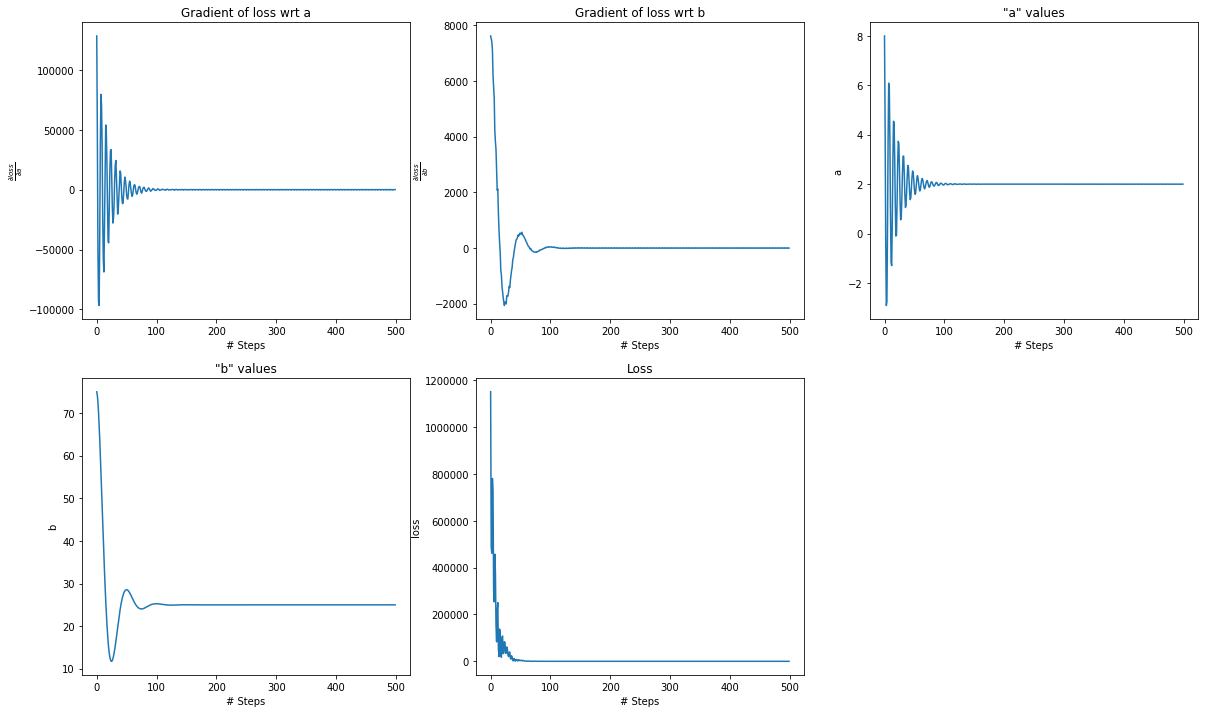

In [17]:
%%time
initial_a = 8
initial_b = 75
num_epochs = 100
theta = np.array([initial_a, initial_b])
beta1 = 0.9
beta2 = 0.999
batch_size = 150
eta = 1e-1
n_batches = int(x.shape[0]/batch_size)
grad_store, abvalue_store, loss_store, velocity_store = init_data_store(num_epochs*n_batches)


mt = np.array([0, 0])
ut = np.array([0, 0])

i=0
for epoch in range(num_epochs):
    
    for batch_idx in range(n_batches):
        
        abvalue_store[i] = theta
        
        # get data and compute gradient
        x_batch, y_batch = get_data_from_batch(x,y, batch_idx, batch_size)
        grad, loss = gradient(x_batch, y_batch, theta)

        # approximate first and second moment
        mt = beta1 * mt + (1 - beta1) * grad
        ut = np.max([beta2 * ut, np.abs(grad)], axis=0)
        
        # update the params
        delta_theta = -1 * eta * mt/(np.sqrt(ut))
        theta = theta + delta_theta
        
        grad_store[i,:] = grad
        loss_store[i] = loss
        i += 1
        
plot_all_results(grad_store, abvalue_store, loss_store)